# Initialization

In [ ]:
try:
  from google.colab import drive
  drive.mount("/content/drive/")
  %cd "/content/drive/MyDrive/ORIE 4741 Project - Lu He Koo"
except ModuleNotFoundError as e:
  print(f'Not in Google Colab: {e}')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ORIE 4741 Project - Lu He Koo


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# For Universal Sentence Encoder
import tensorflow as tf
import tensorflow_hub as hub

# models
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# viz
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Perform data analysis on processed dataset
df = pd.read_csv('cleaned_dset.csv')
print(df.shape)

(6211, 542)


In [ ]:
df.iloc[:,20:35]

,Emirates,Japan Airlines,Korean Air,Qatar Airways,Singapore Airlines,Turkish Airlines,Business,Couple Leisure,Family Leisure,Solo Leisure,0,1,2,3,4
0,False,False,False,False,True,False,False,False,False,True,-0.066933,-0.046129,0.030189,-0.021673,0.063863
1,False,False,False,False,True,False,False,False,False,True,-0.031114,0.016740,-0.030512,0.055375,0.034716
2,False,False,False,False,True,False,False,False,True,False,-0.040741,-0.014491,0.036576,-0.001994,0.033425
3,False,False,False,False,True,False,False,False,False,True,-0.062867,-0.062455,0.039347,0.044484,0.064677
4,False,False,False,False,True,False,False,False,True,False,-0.062610,-0.058504,0.024172,0.023804,0.029772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6206,False,False,True,False,False,False,True,False,False,False,-0.048683,-0.066061,-0.019370,0.032461,0.058822
6207,False,False,True,False,False,False,False,False,False,True,-0.061688,-0.057865,0.041696,0.060193,0.058548
6208,False,False,True,False,False,False,False,False,False,True,-0.059267,-0.026611,0.048795,0.037569,0.062867
6209,False,False,True,False,False,False,True,False,False,False,-0.027380,0.000043,0.064484,-0.002363,0.011352


# Pre-processing

In [ ]:
df = pd.read_csv('airlines_reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Title                   8100 non-null   object
 1   Name                    8100 non-null   object
 2   Review Date             8100 non-null   object
 3   Airline                 8100 non-null   object
 4   Verified                8100 non-null   object
 5   Reviews                 8100 non-null   object
 6   Type of Traveller       8100 non-null   object
 7   Month Flown             8100 non-null   object
 8   Route                   8100 non-null   object
 9   Class                   8100 non-null   object
 10  Seat Comfort            8100 non-null   int64 
 11  Staff Service           8100 non-null   int64 
 12  Food & Beverages        8100 non-null   int64 
 13  Inflight Entertainment  8100 non-null   int64 
 14  Value For Money         8100 non-null   int64 
 15  Over

In [ ]:
# Drop unverified entries
df = df[df['Verified']=='True'].reset_index(drop=True)
df.shape

(6216, 17)

In [ ]:
# Processing dates
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4,
                 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9,
                 'October': 10, 'November': 11, 'December': 12}
df['Month Flown'] = df['Month Flown'].str.split()
flown_df = pd.DataFrame(df['Month Flown'].values.tolist(), columns=['Month Flown', 'Year Flown'])
df.drop('Month Flown', axis=1, inplace=True)
df = pd.concat([df, flown_df], axis=1)
df['Month Flown'] = df['Month Flown'].map(month_mapping)
df['Review Date'] = pd.to_datetime(df['Review Date'])
# Limit to reviews that are within 1 year of flight date
df = df[(df['Review Date'].dt.year - df['Year Flown'].astype(int)) <= 1].reset_index(drop=True)
df.shape

(6211, 18)

In [ ]:
# Turning airline into categorical variables
print(df.Airline.nunique())
airlines = pd.get_dummies(df.Airline)
df = pd.concat([df, airlines], axis=1)
df.drop('Airline', axis=1, inplace=True)

In [ ]:
# Turning traveller type into categorical variables
print(df['Type of Traveller'].unique())
traveller_type = pd.get_dummies(df['Type of Traveller'])
df = pd.concat([df, traveller_type], axis=1)
df.drop('Type of Traveller', axis=1, inplace=True)

In [ ]:
# Mapping class to ordinal ranking
class_map = {'Economy Class': 0, 'Premium Economy': 1, 'Business Class': 2,
             'First Class': 3}
df.Class = df.Class.map(class_map)

In [ ]:
# Mapping Recommended to Boolean
print(df.Recommended.unique())
df.Recommended = df.Recommended.map(lambda s : s == 'yes')

In [ ]:
# Embedding texts
lang_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = lang_model(df['Reviews'])
embeddings = pd.DataFrame(embeddings.numpy())
df = pd.concat([df, embeddings], axis=1)

In [ ]:
# Exporting processed dataset
df.to_csv('cleaned_dset.csv', index=False)

In [ ]:
# Perform data analysis on processed dataset
df = pd.read_csv('cleaned_dset.csv')
df['Review Date'] = pd.to_datetime(df['Review Date'])
print(df.shape)

In [ ]:
df[['Overall Rating', 'Recommended']].corr()
# Overall rating has 0.87 correlation with Recommended, perhaps we should just predict overall rating?

# Data Visualization

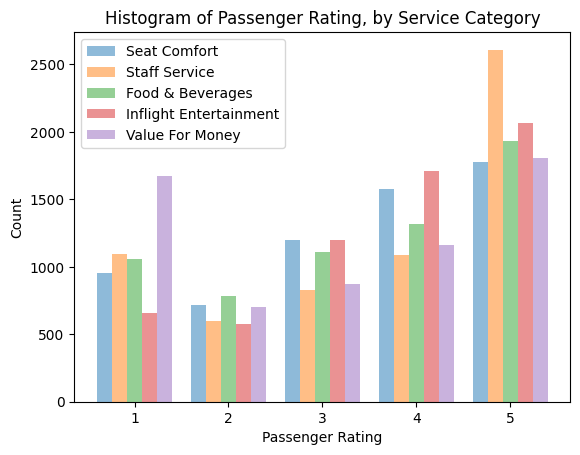

In [ ]:
cols = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money']
plt.hist(df[cols], bins=range(1, 7, 1), alpha=0.5, align='left', label=cols)
plt.xlabel('Passenger Rating')
plt.ylabel('Count')
plt.title('Histogram of Passenger Rating, by Service Category')
plt.legend()
plt.show()

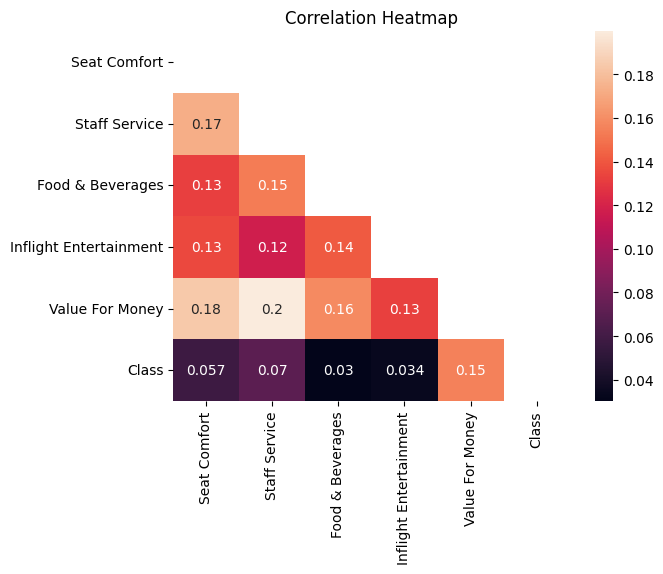

In [ ]:
cols = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money', 'Class']
sns.reset_orig()
corr = df[cols].corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)
plt.title('Correlation Heatmap')
plt.show()

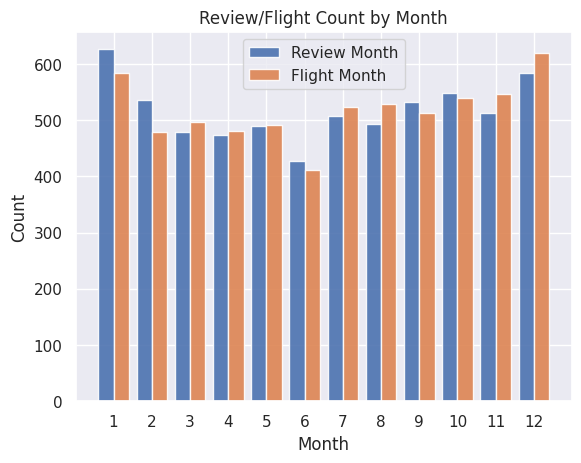

In [ ]:
review_month_df = df['Review Date'].dt.month
flight_month_df = df['Month Flown']
# sns.set_theme()
plt.hist([review_month_df, flight_month_df], alpha=0.9, bins=range(1,14,1),
         align='left', label=['Review Month', 'Flight Month'])
plt.legend()
plt.xticks(range(1, 13, 1))
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Review/Flight Count by Month')
plt.show()

# Linear models

### 1. OLS

In [ ]:
# Predicting using only rating
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money']
rating_df = df[features]
X = sm.add_constant(rating_df)
y = df['Overall Rating']
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Overall Rating   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     4809.
Date:                Thu, 09 May 2024   Prob (F-statistic):               0.00
Time:                        15:11:02   Log-Likelihood:                -11737.
No. Observations:                6211   AIC:                         2.349e+04
Df Residuals:                    6205   BIC:                         2.353e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.2907      0.088    -14.595      0.000      -1.464      -1.117
Seat Comfort               0.0807      0.015      5.368      0.000       0.051       0.110
Staff Service              0.0878      0.014      6.347      0.000       0.061       0.115
Food & Beverages           0.0375      0.014      2.616      0.009       0.009       0.066
Inflight Entertainment     0.0279      0.016      1.757      0.079      -0.003       0.059
Value For Money            1.9407      0.013    145.343      0.000       1.915       1.967
==============================================================================
Omnibus:                      673.350   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2514.316
Skew:                          -0.507   Prob(JB):                         0.00
Kurtosis:                       5.947   Cond. No.                         34.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looking at $P>|t|$ and using 0.05 as a threshold, it seems like everything but inflight entertainment are valid predictors.

If we include all features, including airline flied and travel type, we can observe interesting patterns.

In [ ]:
# Predicting using every feature except sentence encoding
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class', 'Month Flown',
            'Air France', 'All Nippon Airways', 'Cathay Pacific Airways', 'EVA Air', 'Emirates', 'Japan Airlines', 'Qatar Airways', 'Singapore Airlines', 'Turkish Airlines',
            'Couple Leisure','Family Leisure','Solo Leisure']
# Convert True or False into integers
rating_df = df[features].astype(int)
X = sm.add_constant(rating_df)

y = df['Overall Rating']
scores = -1 * cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(scores), np.std(scores))
model = sm.OLS(y, X).fit()
print(model.summary())

2.513850209220567 0.563782553630653
                            OLS Regression Results                            
Dep. Variable:         Overall Rating   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1334.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        19:07:28   Log-Likelihood:                -11600.
No. Observations:                6211   AIC:                         2.324e+04
Df Residuals:                    6191   BIC:                         2.338e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [ ]:
# Predicting using every feature except sentence encoding
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class', 'Month Flown',
            'Air France', 'All Nippon Airways', 'Cathay Pacific Airways', 'EVA Air', 'Emirates', 'Japan Airlines', 'Qatar Airways', 'Singapore Airlines', 'Turkish Airlines',
            'Business','Couple Leisure','Family Leisure','Solo Leisure']
# Convert True or False into integers
rating_df = df[features].astype(int)
X = sm.add_constant(rating_df)

y = df['Overall Rating']
scores = -1 * cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(scores), np.std(scores))
model = sm.OLS(y, X).fit()
print(model.summary())

2.5138502092205672 0.5637825536306532
                            OLS Regression Results                            
Dep. Variable:         Overall Rating   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     1334.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        19:07:17   Log-Likelihood:                -11600.
No. Observations:                6211   AIC:                         2.324e+04
Df Residuals:                    6191   BIC:                         2.338e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [ ]:
rating_df = df[features].astype(int)
scaler = StandardScaler()
X = scaler.fit_transform(rating_df)
param_grid = {'alpha': np.arange(0.01, 1, 0.01)}
gs = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=5)
gs.fit(X, y)
print(gs.best_params_)

scores = -1 * cross_val_score(Lasso(alpha=0.02), X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(scores), np.std(scores))

model = Lasso(alpha=0.02).fit(X, y)
coef_df = pd.DataFrame(zip(features, model.coef_), columns=['Feature', 'Coefficient'])
coef_df[abs(coef_df.Coefficient) > 0]

{'alpha': 0.02}
2.502837445796889 0.5643050488310981


,Feature,Coefficient
0,Seat Comfort,0.044891
1,Staff Service,0.054887
2,Food & Beverages,0.011833
4,Value For Money,2.991452
5,Class,0.190246
7,Air France,-0.008173
8,All Nippon Airways,0.037303
11,Emirates,-0.067242
13,Qatar Airways,0.079391
14,Singapore Airlines,0.064269


In [ ]:
# define calculating MSE using train test split
def OLS_train_test_split_MSE(X, features, y):
    X = sm.add_constant(df[features].astype(int))
    y = df[y]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4741)
    model = sm.OLS(y_train, X_train).fit()
    y_hat = model.predict(X_test)
    train_MSE = mean_squared_error(y_test, y_hat)
    test_MSE = mean_squared_error(y_train, model.predict(X_train))
    return train_MSE, test_MSE
    #display(train_model.summary())

In [ ]:
features= ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment','Value For Money']
OLS_train_test_split_MSE(df,features,'Overall Rating')

(2.5329356203915565, 2.572606254792026)

In [ ]:
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Air France', 'All Nippon Airways', 'Cathay Pacific Airways', 'EVA Air', 'Emirates', 'Japan Airlines', 'Korean Air', 'Qatar Airways', 'Singapore Airlines', 'Turkish Airlines',
            'Couple Leisure','Family Leisure','Solo Leisure']
OLS_train_test_split_MSE(df,features,'Overall Rating')

(2.4011155630452787, 2.469885797110393)

In [ ]:
features_df = df[['Seat Comfort', 'Staff Service', 'Food & Beverages',
            'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Couple Leisure','Family Leisure','Solo Leisure'
            ]].values
embeddings_df = df.iloc[:,30:].values
U, S, V_T = np.linalg.svd(embeddings_df)
full_df = sm.add_constant(np.concatenate([features_df, embeddings_df], axis=1))
y = df['Overall Rating']
full_cv_score = np.mean(-1 * cross_val_score(LinearRegression(), full_df, y,
                                             scoring='neg_mean_squared_error', cv=5))
pca_cv_score = []
k_all = list(range(50, 512, 50))
for k in k_all:
  V_k = V_T[:, :k]
  pca_dset = np.matmul(embeddings_df, V_k)
  full_df = sm.add_constant(np.concatenate([features_df, pca_dset], axis=1))
  cv_score = np.mean(-1 * cross_val_score(LinearRegression(), full_df, y,
                                             scoring='neg_mean_squared_error', cv=5))
  pca_cv_score.append(cv_score)

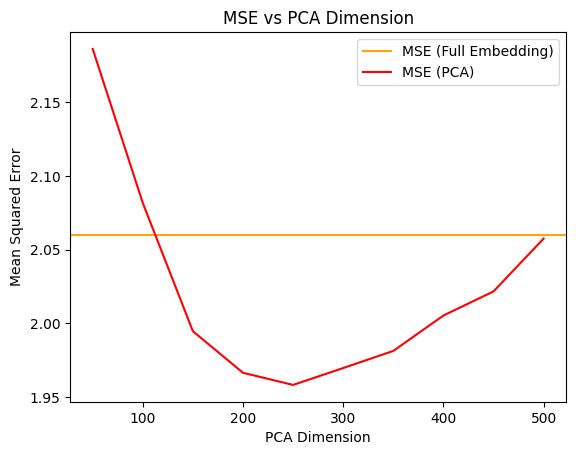

In [ ]:
plt.axhline(full_cv_score, color='orange', label='MSE (Full Embedding)')
plt.plot(k_all, pca_cv_score, label='MSE (PCA)', color='red')
plt.xlabel('PCA Dimension')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs PCA Dimension')
plt.legend()
plt.show()

In [ ]:
embeddings_pca = np.matmul(embeddings_df, V_T[:,:250])
print(embeddings_pca.shape)
full_df = sm.add_constant(np.concatenate([features_df, embeddings_pca], axis=1))
y = df['Overall Rating']
pca_scores = -1 * cross_val_score(LinearRegression(), full_df, y, scoring='neg_mean_squared_error', cv=5)
print(np.mean(pca_scores), np.std(pca_scores))

(6211, 250)
1.9583077772589275 0.5034772702542286


### 2. L1 regularization (Lasso)

In [ ]:
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money']
rating_df = df[features].astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rating_df)

X = sm.add_constant(X_scaled)
y = df['Overall Rating']

# 50/50 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)

# Evaluate the model on test data
y_hat = lasso_model.predict(sm.add_constant(X_test))
MSE = mean_squared_error(y_test, y_hat)
print(f'MSE: {round(MSE,3)}')

coef = lasso_model.coef_
print(coef)

MSE: 2.627
[0.         0.07568661 0.16352848 0.02303864 0.01583269 3.10896819]


In [ ]:
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Air France', 'All Nippon Airways', 'Cathay Pacific Airways', 'EVA Air', 'Emirates', 'Japan Airlines', 'Korean Air', 'Qatar Airways', 'Singapore Airlines', 'Turkish Airlines',
            'Couple Leisure','Family Leisure','Solo Leisure']
rating_df = df[features].astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rating_df)

X = sm.add_constant(X_scaled)
y = df['Overall Rating']

# 50/50 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)

# Evaluate the model on test data
y_hat = lasso_model.predict(sm.add_constant(X_test))
MSE = mean_squared_error(y_test, y_hat)
print(f'MSE: {round(MSE,3)}')

coef = lasso_model.coef_
print(coef)

MSE: 2.495
[ 0.          0.04326249  0.07481074  0.05504366 -0.00747097  2.99416025
  0.20280159  0.01833069 -0.02193605  0.03232406  0.          0.
 -0.06106907  0.02409834 -0.02141941  0.05610307  0.08391572 -0.19503315
 -0.          0.          0.04432024]


# Log

In [ ]:
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money']
rating_df = df[features].astype(int)
X = sm.add_constant(rating_df)
y = df['Recommended']
logit_model = sm.Logit(y, X).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.240078
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Recommended   No. Observations:                 6211
Model:                          Logit   Df Residuals:                     6205
Method:                           MLE   Df Model:                            5
Date:                Thu, 09 May 2024   Pseudo R-squ.:                  0.6532
Time:                        15:12:48   Log-Likelihood:                -1491.1
converged:                       True   LL-Null:                       -4299.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -7.7724      0.278    -27.923      0.000      -8.318      -7.227
Seat Comfort               0.1596      0.035      4.522      0.000       0.090       0.229
Staff Service              0.1285      0.032      3.995      0.000       0.065       0.192
Food & Beverages           0.0561      0.034      1.665      0.096      -0.010       0.122
Inflight Entertainment     0.0014      0.038      0.038      0.970      -0.072       0.075
Value For Money            2.1080      0.053     39.785      0.000       2.004       2.212
==========================================================================================
"""

In [ ]:
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Air France', 'All Nippon Airways', 'Cathay Pacific Airways', 'EVA Air', 'Emirates', 'Japan Airlines', 'Korean Air', 'Qatar Airways', 'Singapore Airlines', 'Turkish Airlines',
            'Couple Leisure','Family Leisure','Solo Leisure']
rating_df = df[features].astype(int)
X = sm.add_constant(rating_df)
y = df['Recommended']
logit_model = sm.Logit(y, X).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.231162
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Recommended   No. Observations:                 6211
Model:                          Logit   Df Residuals:                     6191
Method:                           MLE   Df Model:                           19
Date:                Thu, 09 May 2024   Pseudo R-squ.:                  0.6661
Time:                        15:12:49   Log-Likelihood:                -1435.7
converged:                       True   LL-Null:                       -4299.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -7.0385   3.64e+06  -1.93e-06      1.000   -7.14e+06    7.14e+06
Seat Comfort               0.1215      0.037      3.268      0.001       0.049       0.194
Staff Service              0.0758      0.035      2.192      0.028       0.008       0.144
Food & Beverages           0.0284      0.035      0.801      0.423      -0.041       0.098
Inflight Entertainment    -0.0168      0.040     -0.425      0.671      -0.094       0.061
Value For Money            2.1063      0.055     38.594      0.000       1.999       2.213
Class                      0.3708      0.054      6.902      0.000       0.266       0.476
Month Flown                0.0357      0.014      2.608      0.009       0.009       0.063
Air France                -0.6006   3.64e+06  -1.65e-07      1.000   -7.14e+06    7.14e+06
All Nippon Airways        -0.5302   3.64e+06  -1.46e-07      1.000   -7.14e+06    7.14e+06
Cathay Pacific Airways    -0.6224   3.64e+06  -1.71e-07      1.000   -7.14e+06    7.14e+06
EVA Air                   -0.5994   3.64e+06  -1.65e-07      1.000   -7.14e+06    7.14e+06
Emirates                  -0.9598   3.64e+06  -2.64e-07      1.000   -7.14e+06    7.14e+06
Japan Airlines            -1.0210   3.64e+06   -2.8e-07      1.000   -7.14e+06    7.14e+06
Korean Air                -0.8772   3.64e+06  -2.41e-07      1.000   -7.14e+06    7.14e+06
Qatar Airways             -0.4742   3.64e+06   -1.3e-07      1.000   -7.14e+06    7.14e+06
Singapore Airlines        -0.2154   3.64e+06  -5.92e-08      1.000   -7.14e+06    7.14e+06
Turkish Airlines          -1.1383   3.64e+06  -3.13e-07      1.000   -7.14e+06    7.14e+06
Couple Leisure            -0.2606      0.148     -1.760      0.078      -0.551       0.030
Family Leisure            -0.1826      0.163     -1.123      0.261      -0.501       0.136
Solo Leisure               0.1560      0.136      1.144      0.253      -0.111       0.423
==========================================================================================
"""

# ML Models: Decision Tree, Random Forest, and XG Boost

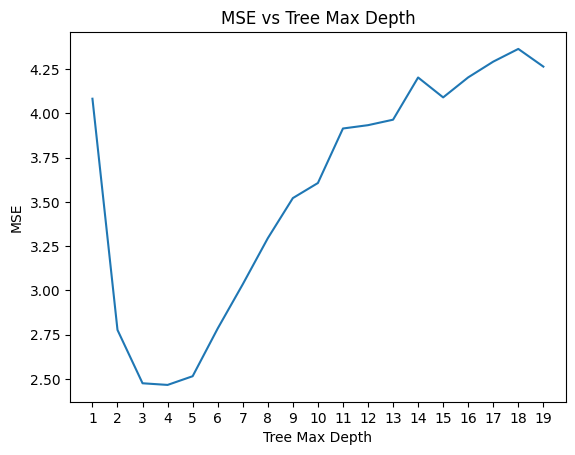

2.455284760319622 0.6020565685706565


In [ ]:
features_df = df[['Seat Comfort', 'Staff Service', 'Food & Beverages',
            'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Couple Leisure','Family Leisure','Solo Leisure'
          ]].values

X = np.concatenate([features_df, embeddings_pca], axis=1)
y = df['Overall Rating']

depths = range(1, 20, 1)
scores = []
for depth in depths:
  score = np.mean(-1*cross_val_score(DecisionTreeRegressor(max_depth=depth), X, y, scoring='neg_mean_squared_error', cv=5))
  scores.append(score)

plt.plot(depths, scores)
plt.xticks(depths)
plt.xlabel('Tree Max Depth')
plt.ylabel('MSE')
plt.title('MSE vs Tree Max Depth')
plt.show()

tree_scores = -1*cross_val_score(DecisionTreeRegressor(max_depth=4), X, y, scoring='neg_mean_squared_error', cv=5)
print(np.mean(tree_scores), np.std(tree_scores))

### 1. Using RMSE to select number of estimators of random forest / XG boost model

In [ ]:
features= ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money']
X = df[features].astype(int).values
y = df['Overall Rating']

NTs = np.arange(1,20,1) # 5 to 20 trees
rmse_RF = []
rmse_XGB = []
for i, NT in enumerate(NTs):
    RF = RandomForestRegressor(
                n_estimators=NT,
                max_depth=2,
                random_state=0)

    XGB = xgb.XGBRegressor(n_estimators=NT,max_depth=2)

    # use default (5-fold) cross-validation to calculate overall rmse
    rmse_RF.append(-1 * np.mean(cross_val_score(RF, X, y, scoring='neg_root_mean_squared_error')))
    rmse_XGB.append(-1 * np.mean(cross_val_score(XGB, X, y, scoring='neg_root_mean_squared_error')))


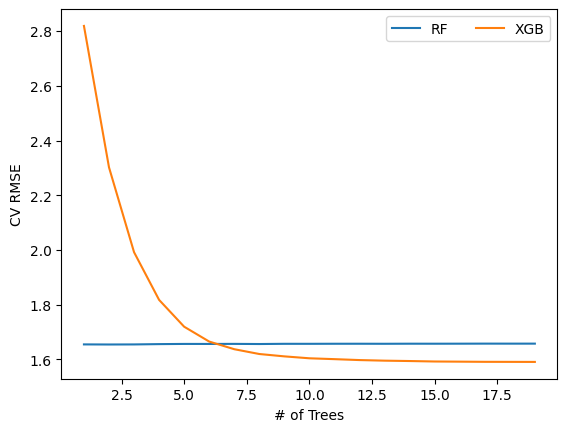

In [ ]:
plt.plot(NTs, rmse_RF, label='RF')
plt.plot(NTs, rmse_XGB, label='XGB')
plt.xlabel('# of Trees')
plt.ylabel('CV RMSE')
plt.legend(ncol=2)
plt.show()

### 2. Using RMSE to select max depth

In [ ]:
features= ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money']
X = df[features].values
y = df['Overall Rating']

NTs = np.arange(1,30,1) # 1-40 max depth
rmse_RF = []
rmse_XGB = []

for i, MD in enumerate(NTs):
    RF = RandomForestRegressor(
                n_estimators=10,
                max_depth=MD,
                random_state=0)

    XGB = xgb.XGBRegressor(n_estimators=10,max_depth=MD)

    # use default (5-fold) cross-validation to calculate overall rmse
    rmse_RF.append(-1 * np.mean(cross_val_score(RF, X, y, scoring='neg_root_mean_squared_error')))
    rmse_XGB.append(-1 * np.mean(cross_val_score(XGB, X, y, scoring='neg_root_mean_squared_error')))

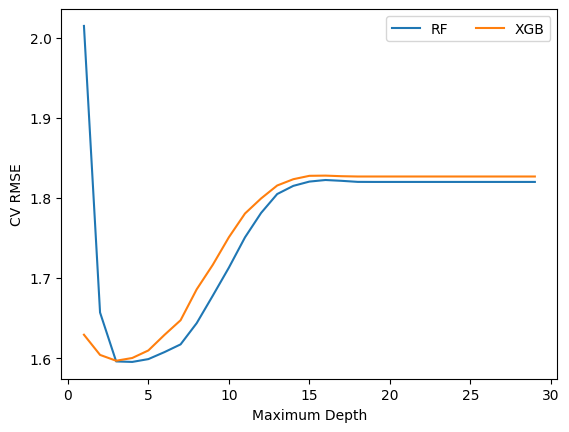

In [ ]:
plt.plot(NTs, rmse_RF, label='RF')
plt.plot(NTs, rmse_XGB, label='XGB')
plt.xlabel('Maximum Depth')
plt.ylabel('CV RMSE')
plt.legend(ncol=2)
plt.show()

#### The above graphs suggest that we should use `num_estimator` = 10 and `max_depth` = 3.

### 3. Actual models: decision tree (viz included)

In [ ]:
# Decision tree
features= ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money']
X = df[features].astype(int).values
y = df['Overall Rating']

max_depth = 4 # Maximum depth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

DTrgr = DecisionTreeRegressor(max_depth=max_depth).fit(X_train,y_train)
y_pred = DTrgr.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)

print(f'R2: {DTrgr.score(X,y)}')
print(f'MSE: {MSE}')

Text(0.5, 1.0, 'Decision Tree with Only Rating')

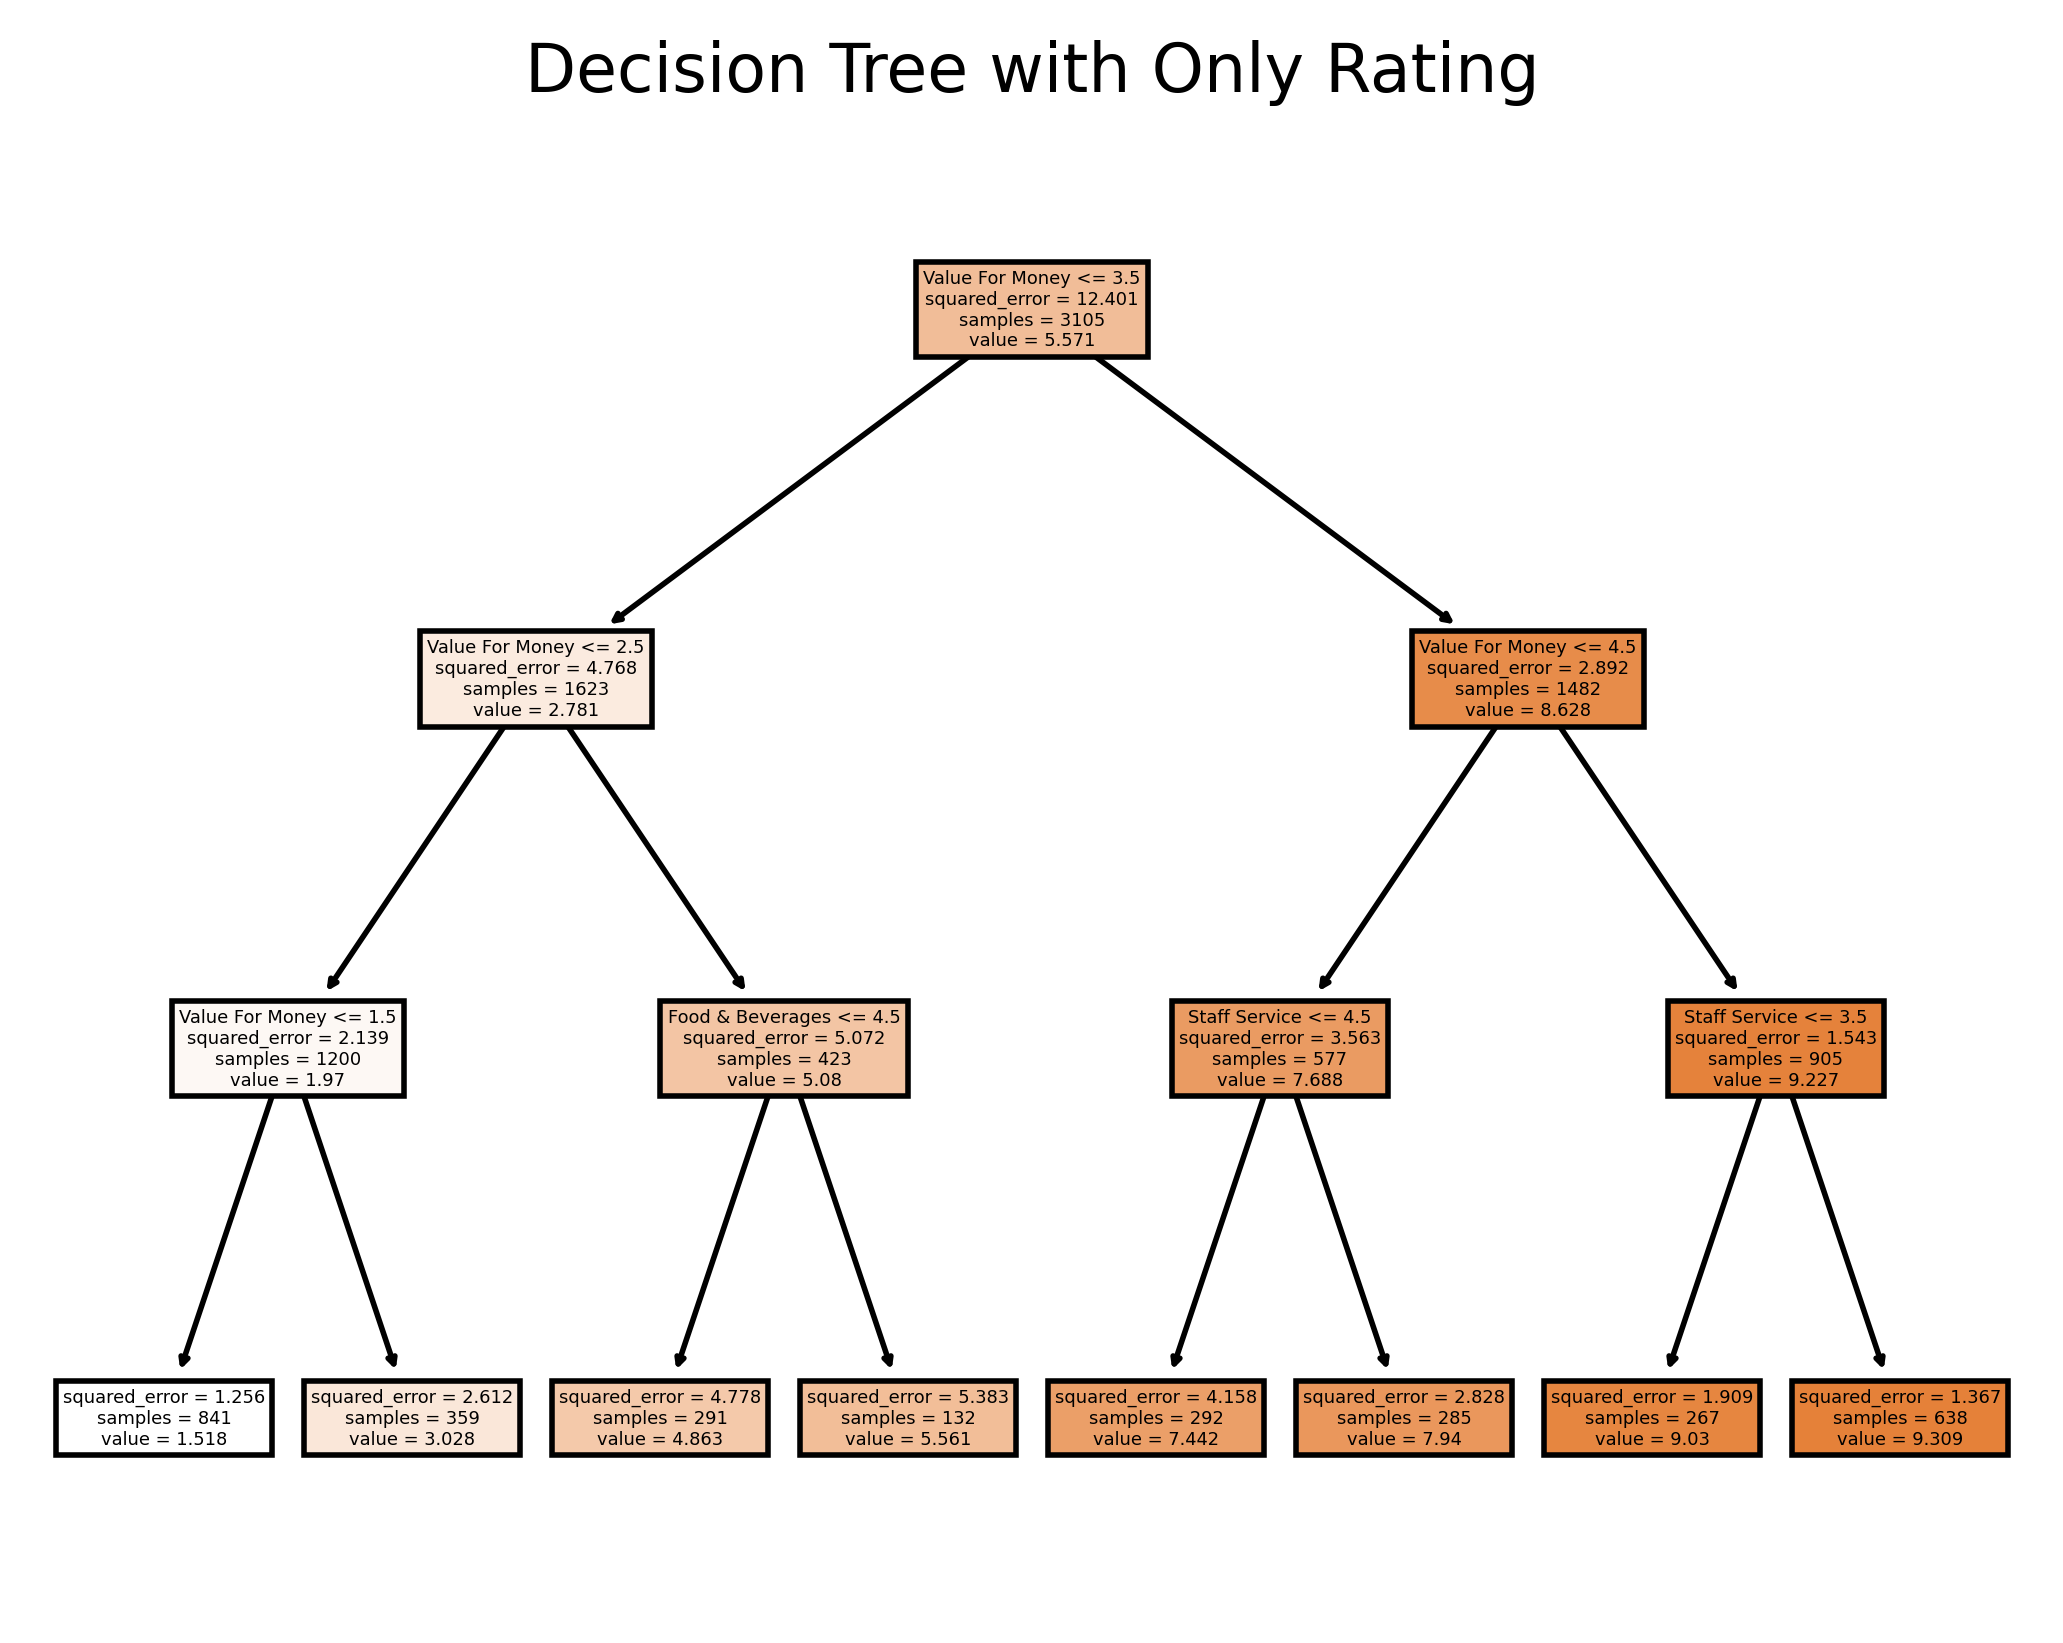

In [ ]:
fig, axes = plt.subplots(dpi=400)
tree.plot_tree(DTrgr,
               feature_names = features,
               class_names=df['Overall Rating'],
               filled = True);
plt.title('Decision Tree with Only Rating')

In [ ]:
# Decision tree
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Air France', 'All Nippon Airways', 'Cathay Pacific Airways', 'EVA Air', 'Emirates', 'Japan Airlines', 'Korean Air', 'Qatar Airways', 'Singapore Airlines', 'Turkish Airlines',
            'Couple Leisure','Family Leisure','Solo Leisure']
X = df[features].astype(int).values
y = df['Overall Rating']

max_depth = 3 # Maximum depth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

DTrgr = DecisionTreeRegressor(max_depth=max_depth).fit(X_train,y_train)
y_pred = DTrgr.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)

print(f'R2: {DTrgr.score(X,y)}')
print(f'MSE: {MSE}')

R2: 0.8005013176142546
MSE: 2.610668436370864


Text(0.5, 1.0, 'Decision Tree with Full Features')

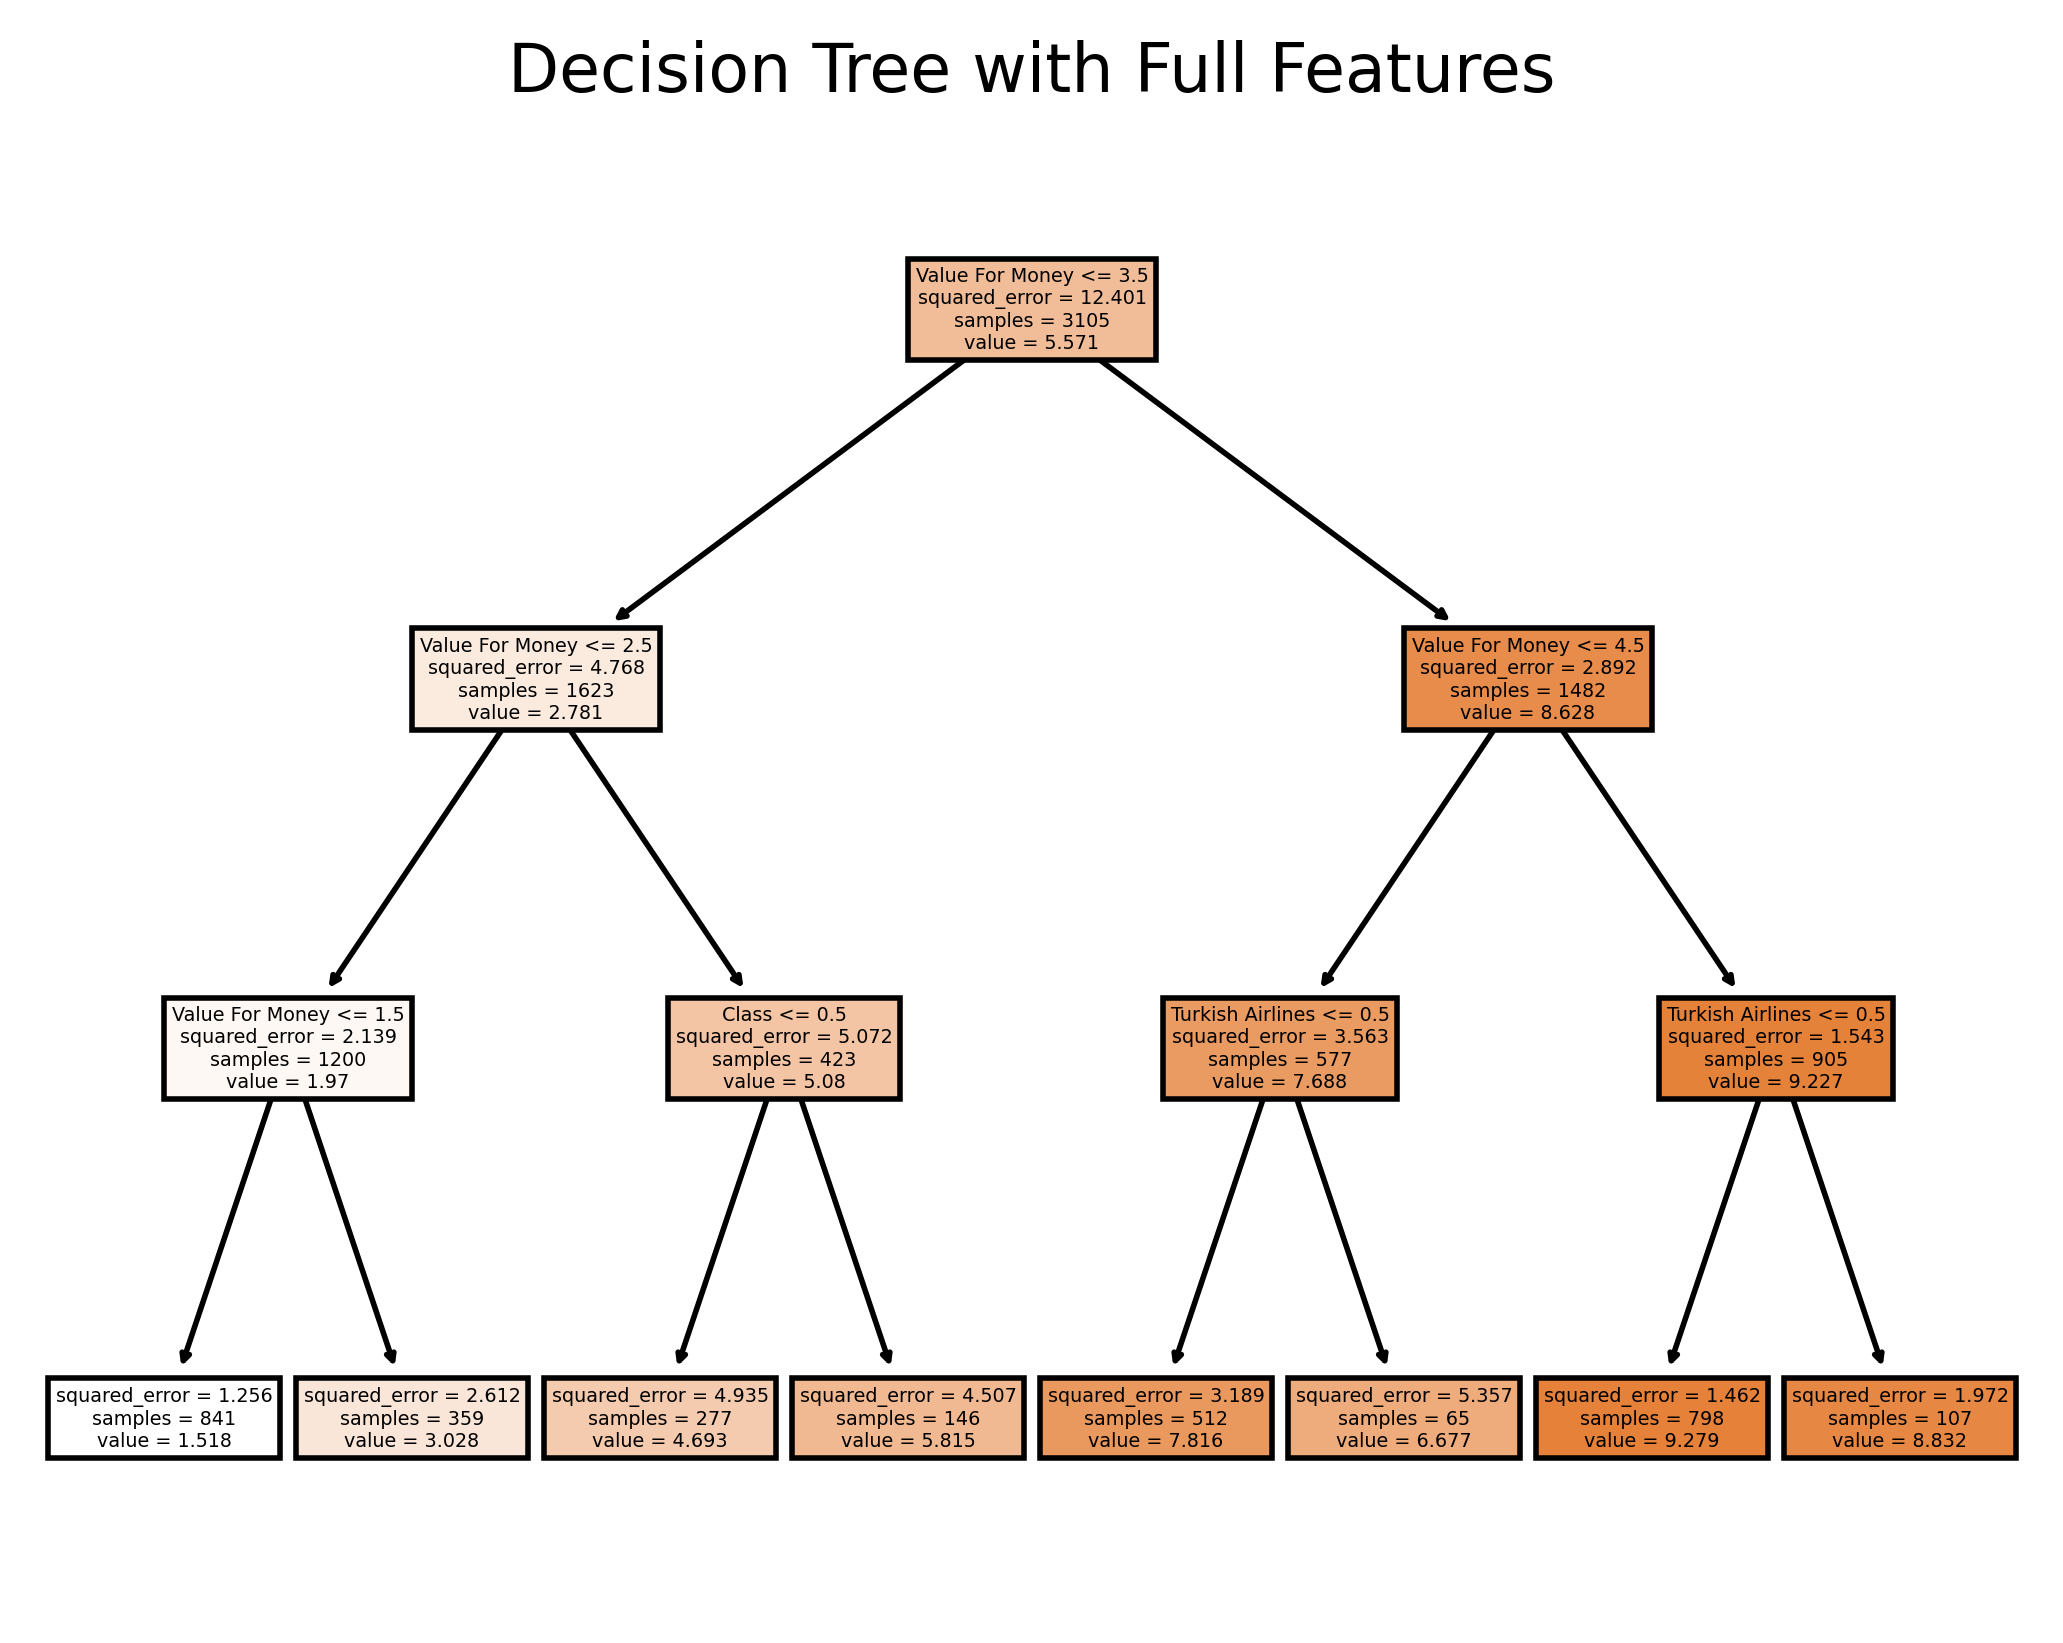

In [ ]:
fig, axes = plt.subplots(dpi=400)
tree.plot_tree(DTrgr,
               feature_names = features,
               class_names=df['Overall Rating'],
               filled = True);
plt.title('Decision Tree with Full Features')

### 4. Actual models: Random Forest (viz included)

In [ ]:
#RF
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages',
            'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Couple Leisure','Family Leisure','Solo Leisure'
          ]
X = np.concatenate([df[features].values, embeddings_pca], axis=1)
y = df['Overall Rating']

n_estimators = 100 # Number of trees
max_depth = 4 # Maximum depth

RFrgr = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=4741)

RF_scores = -1 * cross_val_score(RFrgr, X, y, scoring='neg_mean_squared_error', cv=5)
print(np.mean(RF_scores), np.std(RF_scores))

2.2487756904680176 0.5625747060766088


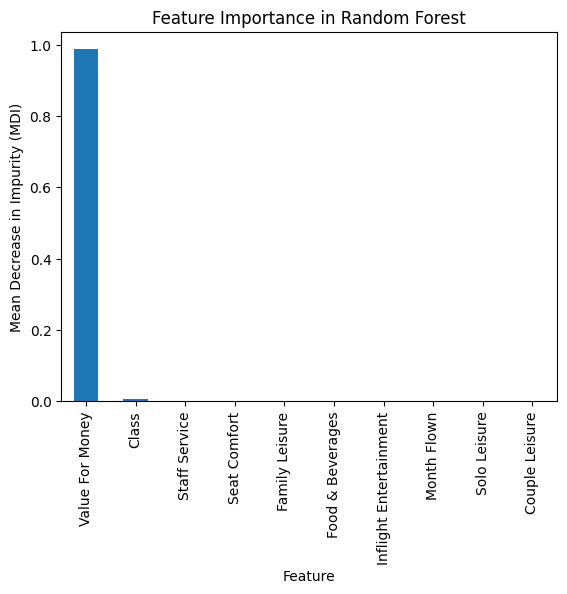

In [ ]:
RFrgr = RFrgr.fit(df[features].values, y)
importances = RFrgr.feature_importances_
forest_importances = pd.Series(importances, index=features)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances.plot.bar()
plt.ylabel('Mean Decrease in Impurity (MDI)')
plt.xlabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.show()

In [ ]:
fig, axes = plt.subplots(dpi=400)
tree.plot_tree(RFrgr.estimators_[0],
               feature_names = features,
               class_names=df['Overall Rating'],
               filled = True);
plt.title('Random Forest with Only Rating')

NameError: name 'plt' is not defined

In [ ]:
#RF
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Air France', 'All Nippon Airways', 'Cathay Pacific Airways', 'EVA Air', 'Emirates', 'Japan Airlines', 'Korean Air', 'Qatar Airways', 'Singapore Airlines', 'Turkish Airlines',
            'Couple Leisure','Family Leisure','Solo Leisure']
X = np.concatenate([df[features].astype(int).values, embeddings_pca], axis=1)
y = df['Overall Rating']

n_estimators = 100 # The number of trees
max_depth = 4 # Maximum depth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

RFrgr = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=0).fit(X_train,y_train)
y_pred = RFrgr.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)

print(f'R2: {RFrgr.score(X,y)}')
print(f'MSE: {MSE}')

R2: 0.8020165833474474
MSE: 2.59256438754617


Text(0.5, 1.0, 'Random Forest with Full Features')

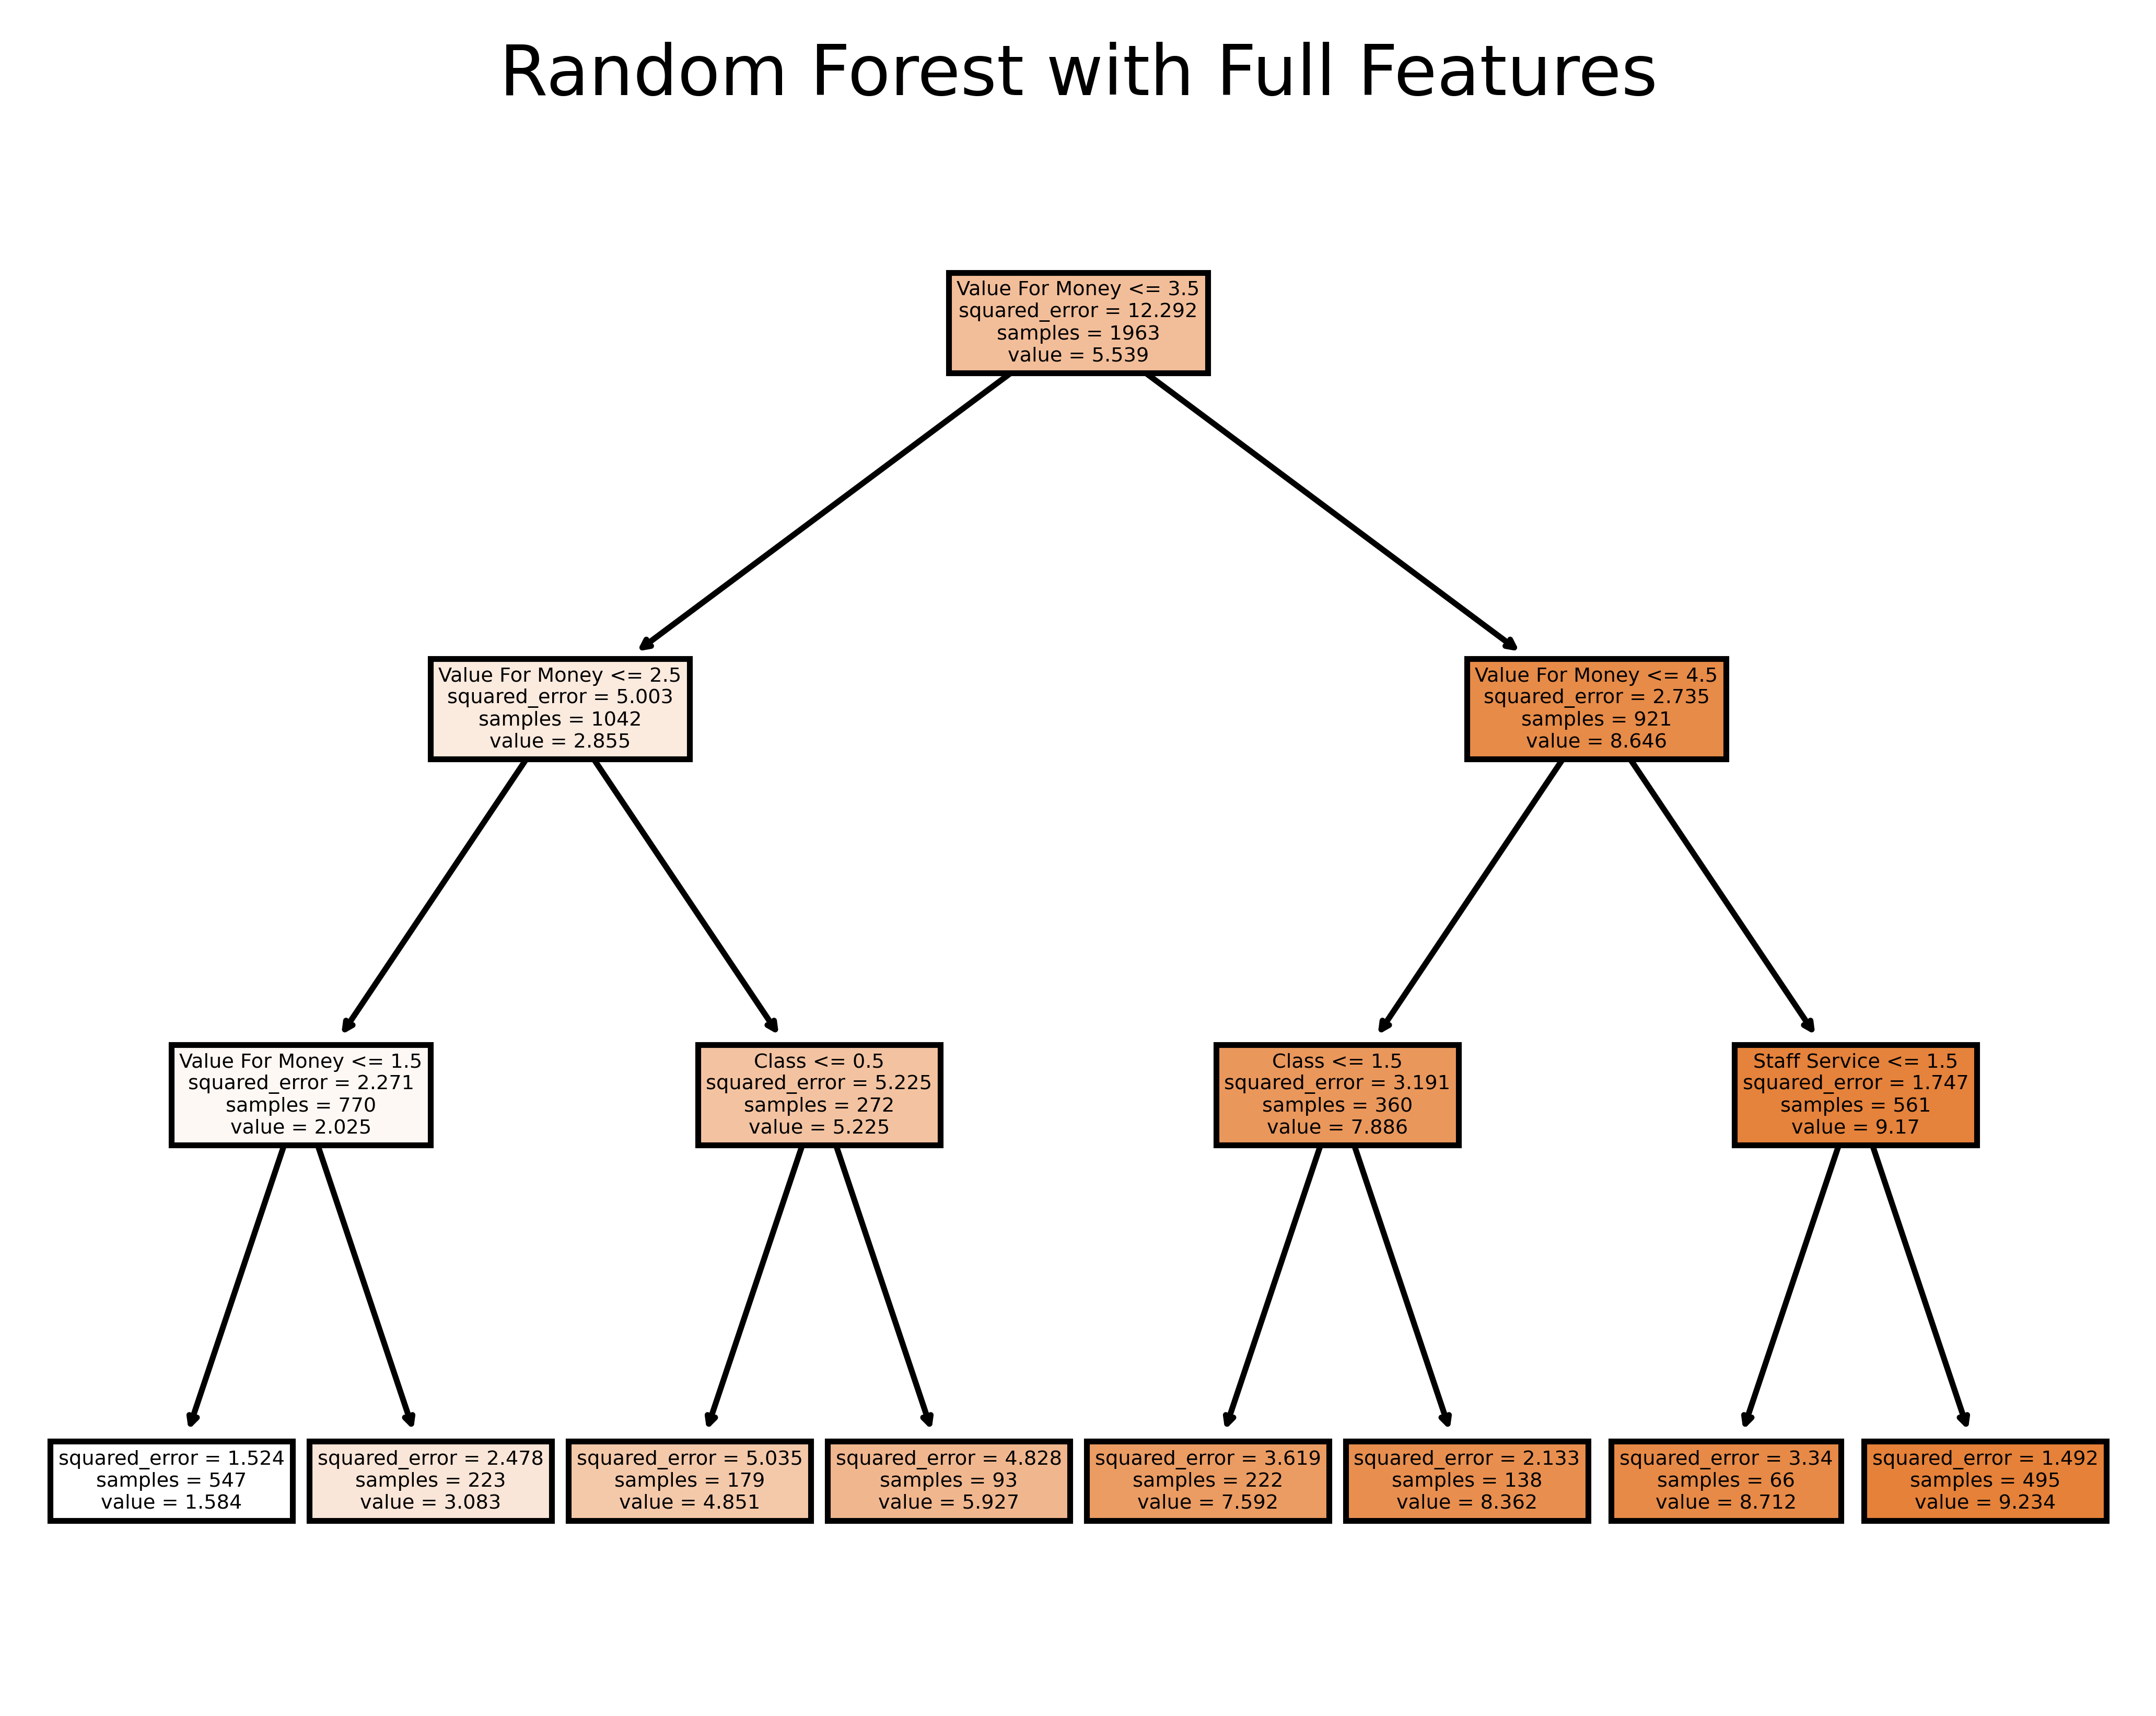

In [ ]:
fig, axes = plt.subplots(dpi=800)
tree.plot_tree(RFrgr.estimators_[0],
               feature_names = features,
               class_names=df['Overall Rating'],
               filled = True);
plt.title('Random Forest with Full Features')

Text(0.5, 1.0, 'Random Forest with Full Features')

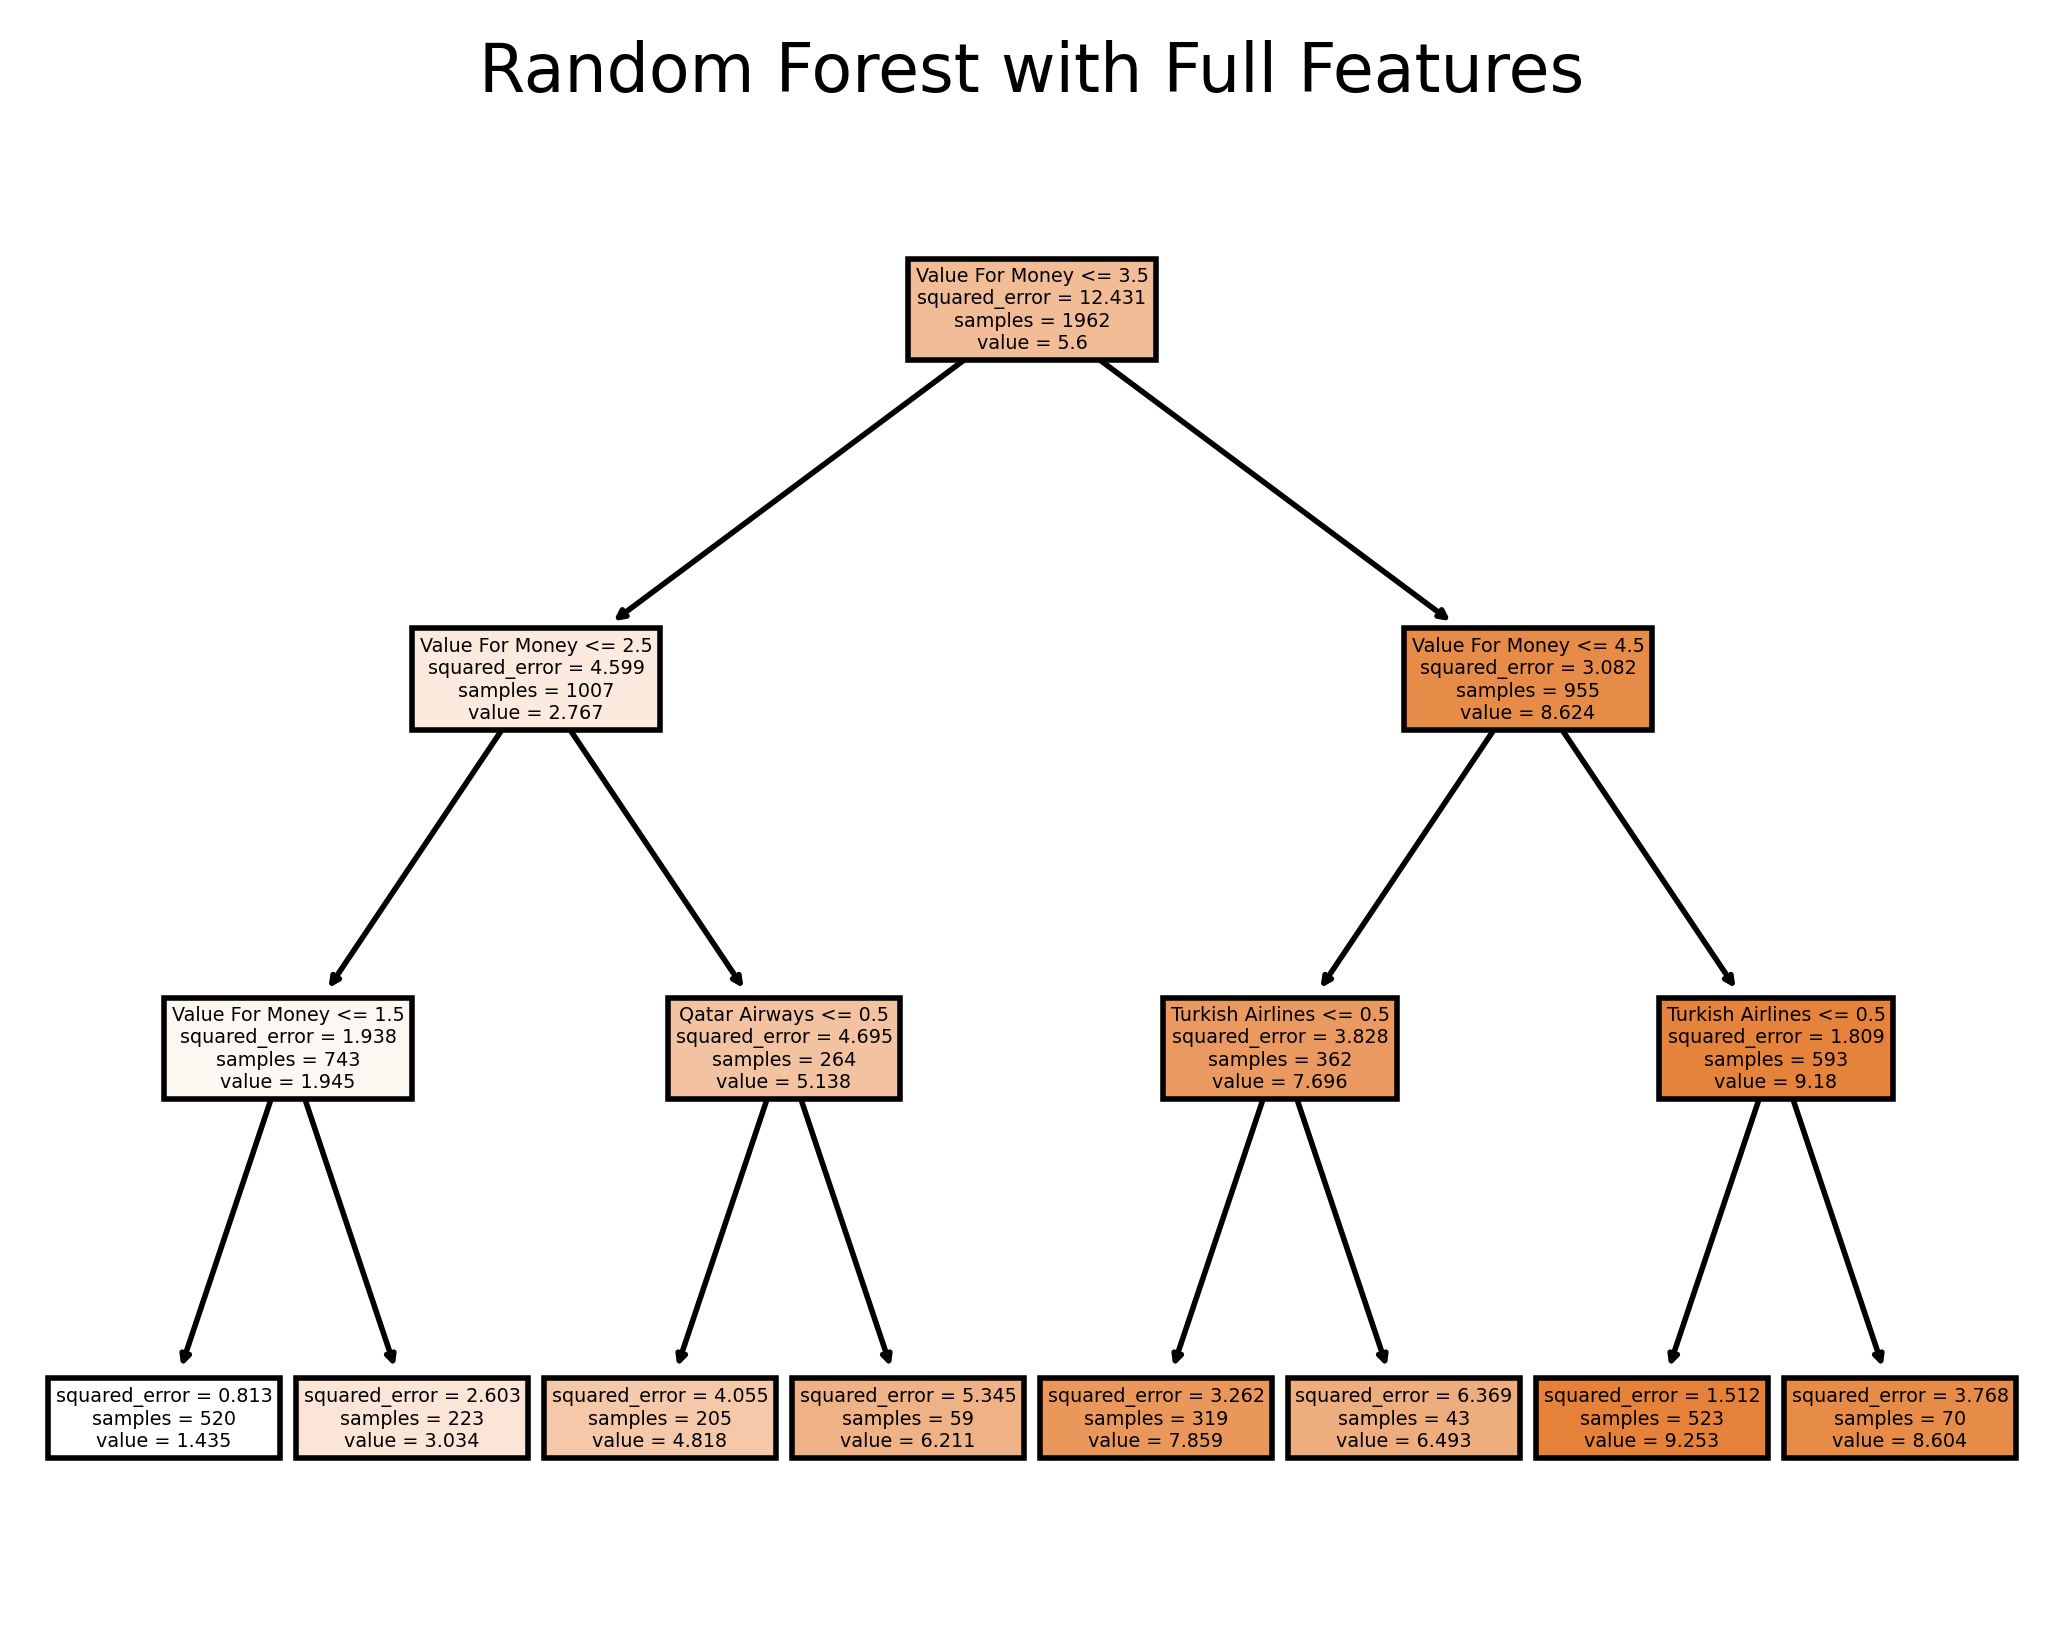

In [ ]:
fig, axes = plt.subplots(dpi=400)
tree.plot_tree(RFrgr.estimators_[4],
               feature_names = features,
               class_names=df['Overall Rating'],
               filled = True);
plt.title('Random Forest with Full Features')

### 5. Actual models: XG Boost (viz included)

In [ ]:
#XG Boost
features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Couple Leisure','Family Leisure','Solo Leisure']
X = np.concatenate([df[features].astype(int).values, embeddings_pca], axis=1)
y = df['Overall Rating']

n_estimators = 100 # The number of trees
max_depth = 4 # Maximum depth

XGBrgr = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth)
boost_scores = -1 * cross_val_score(XGBrgr, X, y, scoring='neg_mean_squared_error', cv=5)
print(np.mean(boost_scores), np.std(boost_scores))

2.1539035891688845 0.5478803317581061


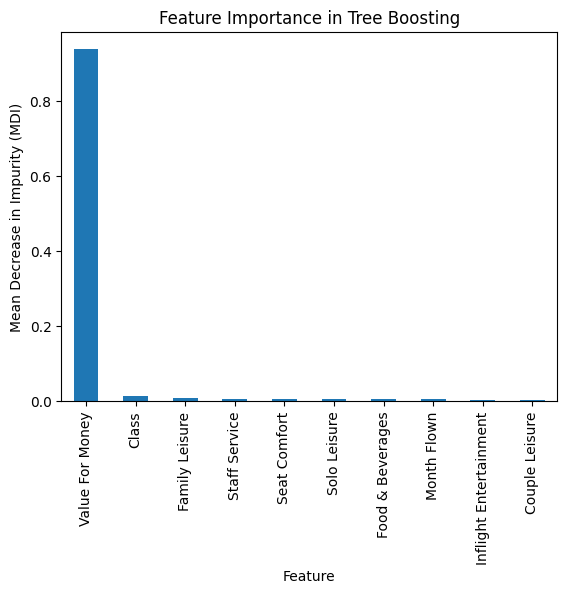

In [ ]:
XGBrgr = XGBrgr.fit(df[features].values, y)
importances = XGBrgr.feature_importances_
forest_importances = pd.Series(importances, index=features)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances.plot.bar()
plt.ylabel('Mean Decrease in Impurity (MDI)')
plt.xlabel('Feature')
plt.title('Feature Importance in Tree Boosting')
plt.show()

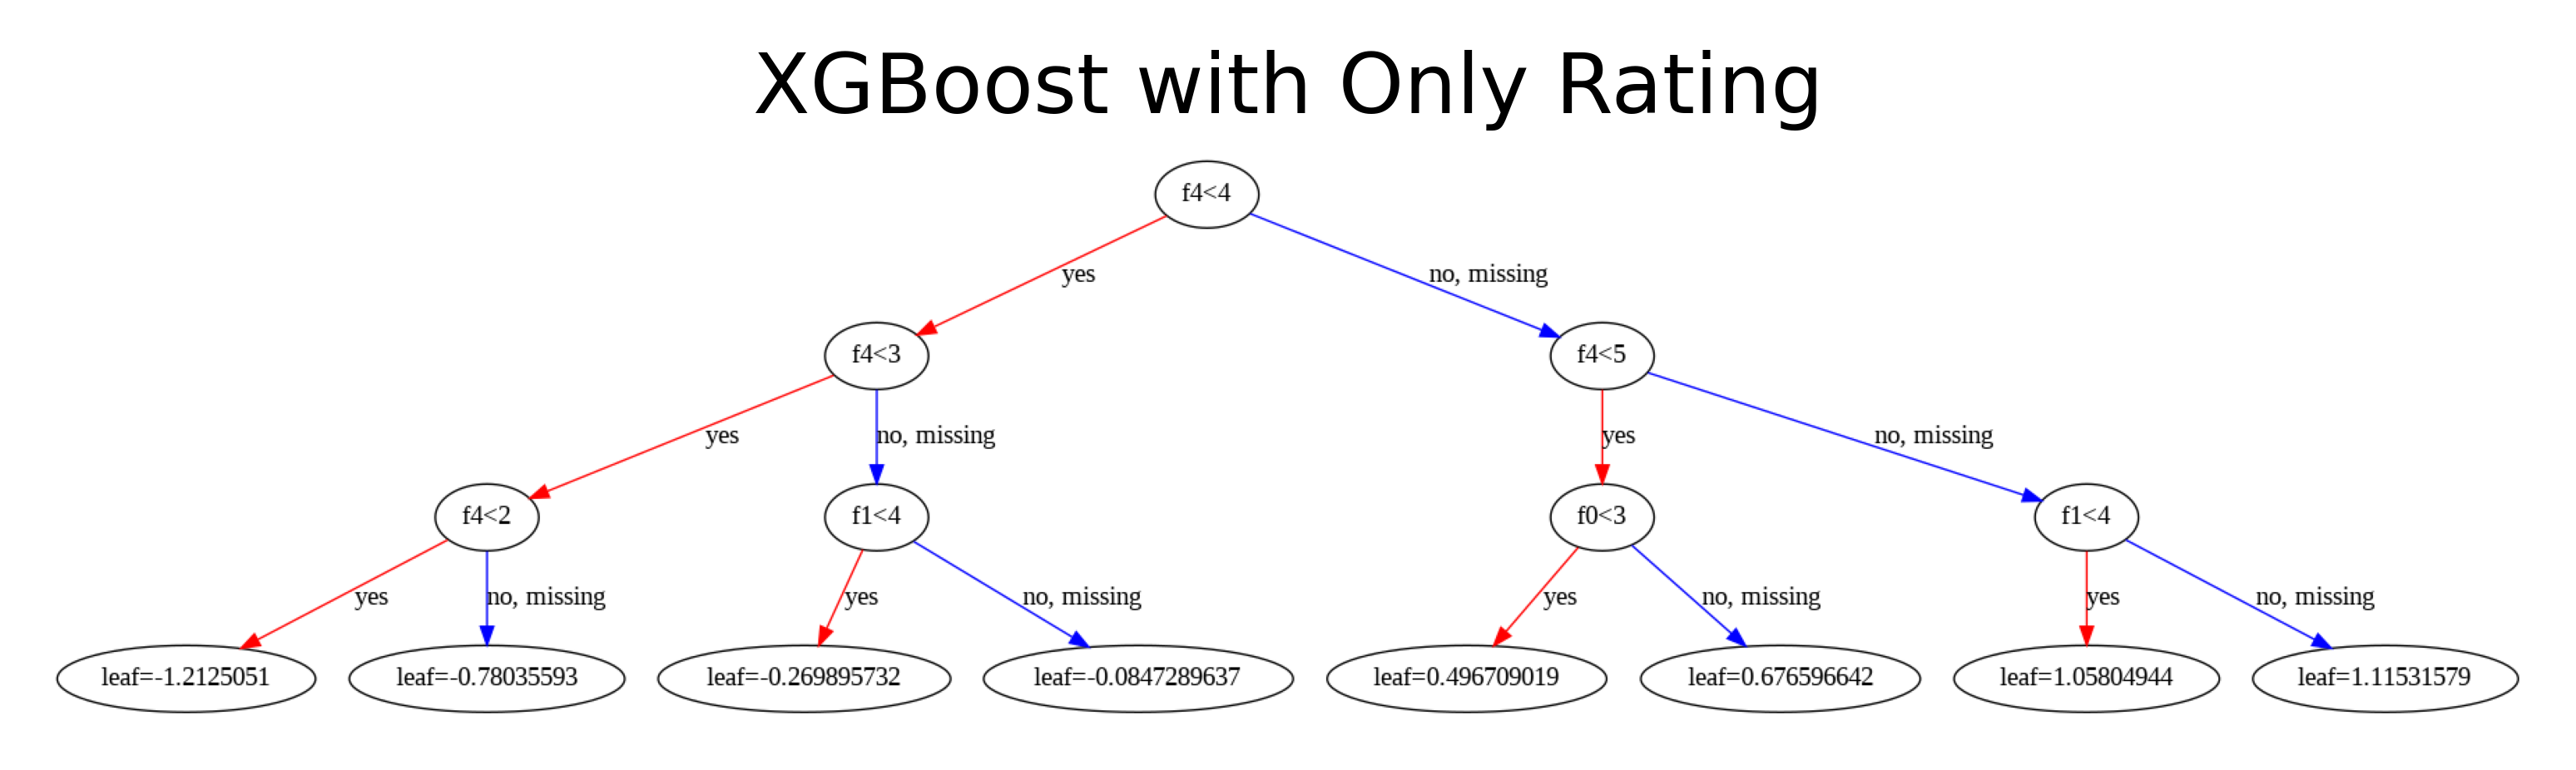

In [ ]:
fig, ax = plt.subplots(dpi=600)
xgb.plot_tree(XGBrgr, num_trees=0, ax=ax)
plt.title('XGBoost with Only Rating')
plt.show()

In [ ]:
#XG Boost

features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money','Class','Month Flown',
            'Air France', 'All Nippon Airways', 'Cathay Pacific Airways', 'EVA Air', 'Emirates', 'Japan Airlines', 'Korean Air', 'Qatar Airways', 'Singapore Airlines', 'Turkish Airlines',
            'Couple Leisure','Family Leisure','Solo Leisure']
X = df[features].astype(int).values
y = df['Overall Rating']

n_estimators = 10 # The number of trees
max_depth = 3 # Maximum depth

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

XGBrgr = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth).fit(X, y)
y_pred = XGBrgr.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)

print(f'R2: {XGBrgr.score(X,y)}')
print(f'MSE: {MSE}')

R2: 0.8115122897813409
MSE: 2.451841834499893


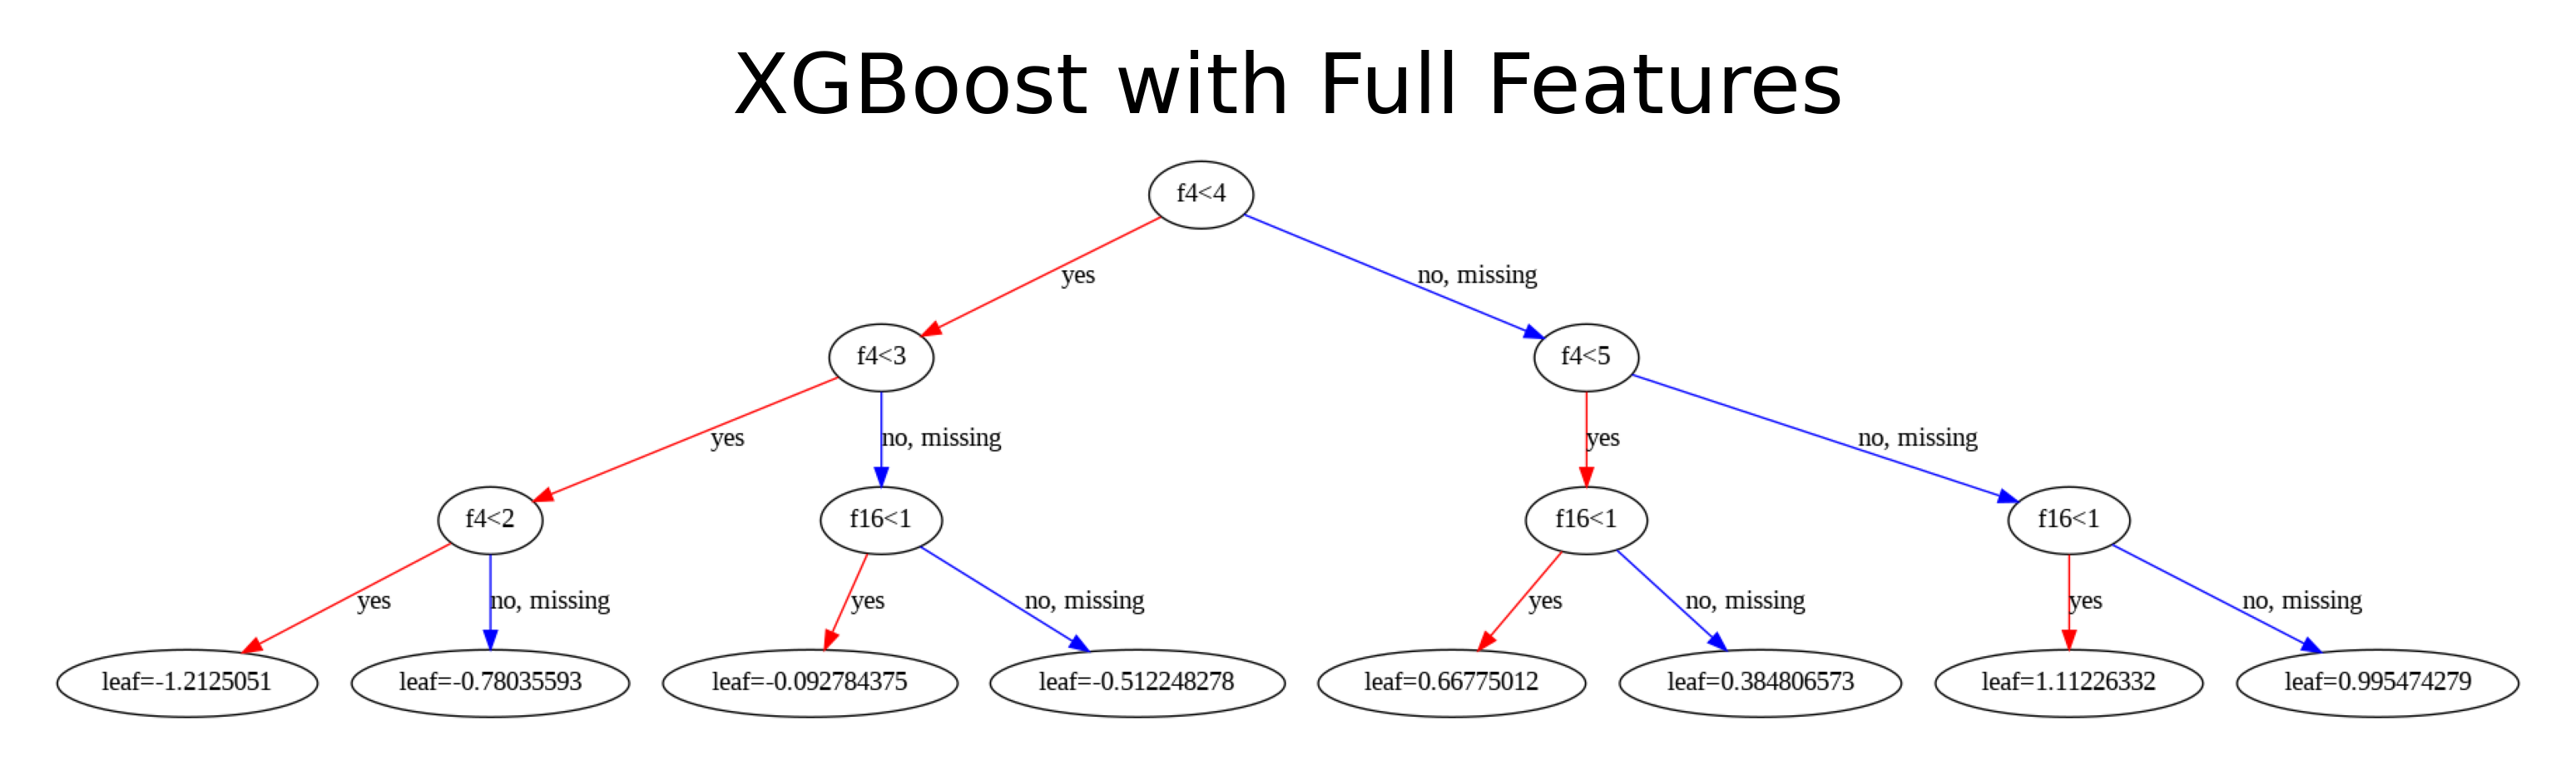

In [ ]:
fig, ax = plt.subplots(dpi=600)
xgb.plot_tree(XGBrgr, num_trees=0, ax=ax)
plt.title('XGBoost with Full Features')
plt.show()